In [64]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from datetime import datetime
import os
import importlib
import qlbmlib
importlib.reload(qlbmlib)

<module 'qlbmlib' from 'd:\\Data\\Codes\\Quantum\\Research\\qlbmlib.py'>

In [65]:
def get_cross_initial_distribution(sites: tuple[int, int], 
                                 line_width: int = 2,
                                 background_density: float = 0.1,
                                 cross_density: float = 0.9) -> NDArray[np.float64]:
    """
    Create a cross-shaped initial distribution with full-width lines.
    
    Args:
        sites: Tuple of (height, width) for the grid
        line_width: Width of the cross lines in lattice units
        background_density: Density value outside the cross
        cross_density: Density value in the cross
        
    Returns:
        density: Initial density distribution with a cross pattern
    """
    # Initialize density array with background value
    density = np.full(sites, background_density)
    
    # Calculate center points
    center_x = sites[0] // 2
    center_y = sites[1] // 2
    
    # Create horizontal line (full width)
    density[:, center_y-line_width:center_y+line_width] = cross_density
    
    # Create vertical line (full height)
    density[center_x-line_width:center_x+line_width, :] = cross_density
    
    return density

def get_vortex_velocity_field(sites: tuple[int, int], magnitude: float = 0.2, clockwise: bool = True) -> NDArray[np.float64]:
    """
    Create a vortex velocity field with proper radial scaling.
    
    Args:
        sites: Tuple of (height, width) for the grid
        magnitude: Maximum velocity magnitude
        clockwise: Direction of rotation
        
    Returns:
        velocity_field: Array of shape (2, height, width) containing the velocity components
    """
    # Create grid points
    x = np.arange(sites[0])
    y = np.arange(sites[1])
    X, Y = np.meshgrid(x, y)
    
    # Center the coordinates
    center_x = sites[0] / 2
    center_y = sites[1] / 2
    X_centered = X.T - center_x
    Y_centered = Y.T - center_y
    
    # Calculate radial distance and avoid division by zero
    r = np.sqrt(X_centered**2 + Y_centered**2)
    r = r + 1e-6  # Avoid division by zero
    
    # Calculate velocity components for vortex
    direction = 1 if clockwise else -1
    v_theta = magnitude * direction
    
    # Compute velocity components
    u = -v_theta * Y_centered / r  # Horizontal velocity
    v = v_theta * X_centered / r   # Vertical velocity
    
    return np.stack([u, v])

In [73]:
# Create sites configuration
sites_cross = (16, 16)  # 16x16 lattice
links = [[0,0], [1, 0], [0,1], [-1,0], [0,-1], [1,1], [-1,1], [-1,-1], [1,-1]]  # 9 velocities
weights = [4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36]  

links2 = [[0,0], [2,1], [-2,-1]] 
weights2 = [2/3, 1/6, 1/6] 
speed_of_sound = 1/np.sqrt(3)

# Create cross-shaped initial distribution
initial_dist_cross = get_cross_initial_distribution(sites_cross, line_width=2)

# Create both velocity fields
clockwise_field = get_vortex_velocity_field(sites_cross, magnitude=0.5, clockwise=True)
zero_field = np.zeros((2,16,16))

# Configuration for simulation (10 iterations each)
config_cross = [
    (15, clockwise_field, links, weights, speed_of_sound),
    (10, zero_field, links2, weights2, speed_of_sound)
]

# Create experiment directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
dirname = f"experiments/2DQ9Cross_{timestamp}"
os.makedirs(dirname, exist_ok=True)

# Define output files
classical_csv = f"{dirname}/classical.csv"
quantum_csv = f"{dirname}/quantum.csv"
comparison_fig = f"{dirname}/comparison.png"
rmse_plot = f"{dirname}/rmse_plot.png"


In [74]:
# Run both simulations
_ = qlbmlib.simulate_flow_classical(initial_dist_cross, config_cross, classical_csv)
_ = qlbmlib.simulate_flow(initial_dist_cross, config_cross, quantum_csv, True)

Classical simulation: iterations 0-15/25
Classical Iteration 1/25
Classical Iteration 2/25
Classical Iteration 3/25
Classical Iteration 4/25
Classical Iteration 5/25
Classical Iteration 6/25
Classical Iteration 7/25
Classical Iteration 8/25
Classical Iteration 9/25
Classical Iteration 10/25
Classical Iteration 11/25
Classical Iteration 12/25
Classical Iteration 13/25
Classical Iteration 14/25
Classical Iteration 15/25
Classical simulation: iterations 15-25/25
Classical Iteration 16/25
Classical Iteration 17/25
Classical Iteration 18/25
Classical Iteration 19/25
Classical Iteration 20/25
Classical Iteration 21/25
Classical Iteration 22/25
Classical Iteration 23/25
Classical Iteration 24/25
Classical Iteration 25/25
Classical simulation complete. Results saved to experiments/2DQ9Cross_20250607_170854/classical.csv
Circuit configuration: will run iterations 0-15/25 with this configuration
Iteration 1 running...
Iteration 1/25:
  Compilation: 1.937 seconds
  Execution: 1.039 seconds
  Tota

In [ ]:
def save_simulation_snapshots(filename: str, dimensions: tuple[int, ...],  
                            output_path: str, iterations: list[int] = [0, 9, 10, 19]) -> None:
    """Save simulation snapshots at specified iterations as a 2x2 figure.
    
    Args:
        filename: Path to CSV file containing simulation data
        dimensions: Tuple of dimensions for reshaping the data
        iterations: List of iterations to display
        output_path: Optional path to save the figure
    """
    df = pd.read_csv(filename, header=None)
    if max(iterations) >= len(df):
        raise ValueError(f"Max iteration {max(iterations)} exceeds data length {len(df)}")
    
    # Get global min and max for consistent colorbar scale
    all_frames = [np.array(df.iloc[i]).reshape(dimensions, order='F') for i in iterations]
    vmin = min(frame.min() for frame in all_frames)
    vmax = max(frame.max() for frame in all_frames)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Simulation Snapshots', fontsize=16)
    
    for idx, iter_num in enumerate(iterations):
        ax = axes[idx // 2, idx % 2]
        print(np.sum(np.array(df.iloc[iter_num])))
        frame_data = np.array(df.iloc[iter_num]).reshape(dimensions, order='F')
        im = ax.imshow(frame_data.T, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
        # Create a more compact colorbar
        cbar = plt.colorbar(im, ax=ax, label='Density', fraction=0.046, pad=0.04)
        ax.set_title(f't = {iter_num} {"Vortex" if iter_num < 15 else "Restricted Propagation"}', pad=10)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Snapshots saved to {output_path}")

In [75]:
# Save visualizations
save_simulation_snapshots(classical_csv, sites_cross, f"{dirname}/classical_snapshots.png", [0, 10, 15, 25])
save_simulation_snapshots(quantum_csv, sites_cross, f"{dirname}/quantum_snapshots.png", [0, 10, 15, 25])
qlbmlib.save_rmse_comparison(classical_csv, quantum_csv, sites_cross, rmse_plot)

115.19999999999999
115.19999999999993
115.1999999999999
115.19999999999983
Snapshots saved to experiments/2DQ9Cross_20250607_170854/classical_snapshots.png
115.19999999999999
115.21021144114684
115.21642946952616
115.21642946953037
Snapshots saved to experiments/2DQ9Cross_20250607_170854/classical_snapshots.png
115.19999999999999
115.21021144114684
115.21642946952616
115.21642946953037
Snapshots saved to experiments/2DQ9Cross_20250607_170854/quantum_snapshots.png
Snapshots saved to experiments/2DQ9Cross_20250607_170854/quantum_snapshots.png
RMSE comparison saved to experiments/2DQ9Cross_20250607_170854/rmse_plot.png
RMSE comparison saved to experiments/2DQ9Cross_20250607_170854/rmse_plot.png


In [ ]:
def animate_density_evolution(dimensions: tuple[int, int], filename: str, interval: int = 100, repeat: bool = True) -> FuncAnimation:
    """Create an animation of the density evolution.
    
    Args:
        dimensions: Tuple of (width, height) for the grid
        filename: Path to CSV file containing simulation data
        interval: Time between frames in milliseconds
        repeat: Whether to loop the animation
    """
    df = pd.read_csv(filename, header=None)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    img = ax.imshow(np.zeros(dimensions).T, cmap='viridis', origin='lower', animated=True)
    plt.colorbar(img, label='Density')
    
    ax.set_title('Density Evolution')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    def init():
        img.set_array(np.zeros(dimensions).T)
        return [img]
    
    def update(frame):
        # Reshape the flattened data back to 2D and transpose
        current_density = df.iloc[frame].values.reshape(dimensions, order='F').T
        img.set_array(current_density)
        img.set_clim(vmin=df.values.min(), vmax=df.values.max())
        # Update title to show timestep and rotation direction
        ax.set_title(f'Time: {frame} {"Clockwise" if frame < 10 else "Counter-clockwise"}')
        return [img]
    
    anim = FuncAnimation(fig, update, frames=len(df),
                        init_func=init, blit=False,
                        interval=interval, repeat=repeat)
    
    return anim

In [ ]:
while True:
    plt.close()

KeyboardInterrupt: 

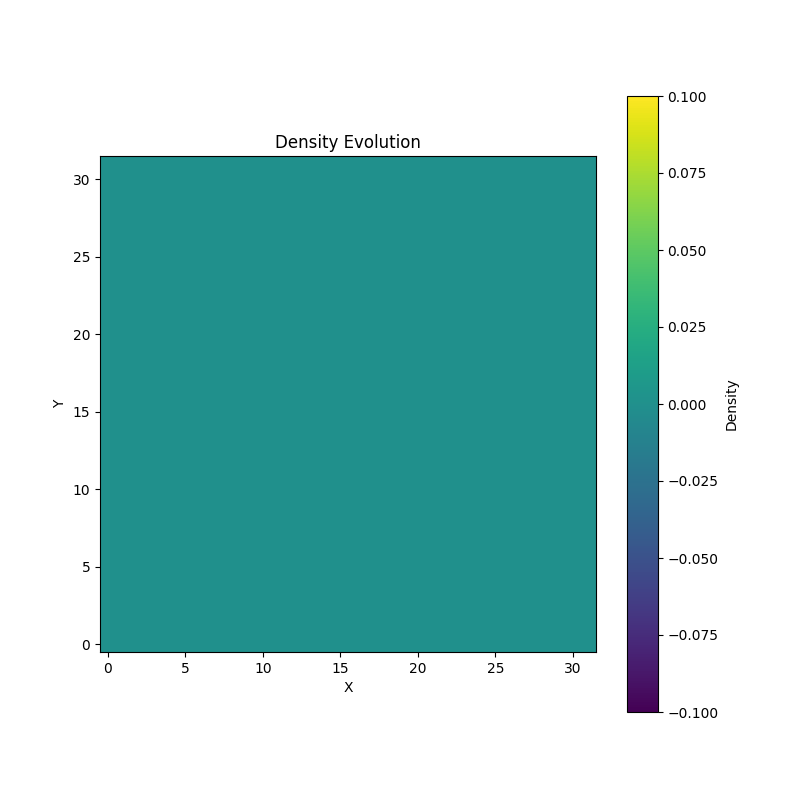

In [ ]:
%matplotlib widget
anim = animate_density_evolution(sites_cross, classical_csv)

plt.show()